In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # import cv2

In [2]:
import os
print(os.listdir("../input"))

['images', 'chest-xray-pneumonia']


In [3]:
DIR = os.listdir('../input/chest-xray-pneumonia/chest_xray')
print(DIR)

['chest_xray', '__MACOSX', 'val', 'test', 'train']


## train, test, validation folder

In [4]:
train_folder = '../input/chest-xray-pneumonia/chest_xray/train'
test_folder = '../input/chest-xray-pneumonia/chest_xray/test'
val_folder = '../input/chest-xray-pneumonia/chest_xray/val'

## import visualization package

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random

In [6]:
labels = ["NORMAL", "PNEUMONIA"] # each folder has two sub folder name "PNEUMONIA", "NORMAL"
IMG_SIZE = 256 # resize image

def get_data_train(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([new_array, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [7]:
train = get_data_train(train_folder)
test = get_data_train(test_folder)
val = get_data_train(val_folder)

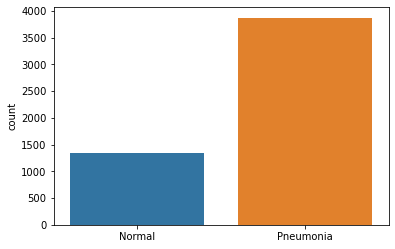

In [8]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Normal")
    else:
        l.append("Pneumonia")
        
sns.countplot(l)

In [9]:
X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

# Noramalization

In [10]:
X_train = np.array(X_train) / 255.0
X_val = np.array(X_val) / 255.0
X_test = np.array(X_test) / 255.0

In [11]:
X_test.shape

(624, 256, 256)

# reshape train, test and validation

In [12]:
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(y_test)

# Load important packages

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Conv2D, Activation, Dense, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential

# Training the Model

In [14]:
X_train.shape

(5216, 256, 256, 1)

In [15]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding="same", input_shape=X_train.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation="relu"))

model.add(Dense(1))
model.add(Activation("sigmoid"))

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), shuffle=True, callbacks=[callback])
scores = model.evaluate(X_test, y_test)

model.save("cnn_model.bin")

Epoch 1/50
163/163 [==============================] - 8s 48ms/step - loss: 0.5108 - accuracy: 0.7496 - val_loss: 0.6573 - val_accuracy: 0.6875
Epoch 2/50
163/163 [==============================] - 8s 47ms/step - loss: 0.3002 - accuracy: 0.8794 - val_loss: 0.5769 - val_accuracy: 0.7500
Epoch 3/50
163/163 [==============================] - 7s 45ms/step - loss: 0.2021 - accuracy: 0.9212 - val_loss: 0.5423 - val_accuracy: 0.7500
Epoch 4/50
163/163 [==============================] - 7s 45ms/step - loss: 0.1666 - accuracy: 0.9363 - val_loss: 0.4792 - val_accuracy: 0.8125
Epoch 5/50
163/163 [==============================] - 7s 45ms/step - loss: 0.1564 - accuracy: 0.9396 - val_loss: 0.4800 - val_accuracy: 0.8125
Epoch 6/50
163/163 [==============================] - 7s 45ms/step - loss: 0.1503 - accuracy: 0.9421 - val_loss: 0.4676 - val_accuracy: 0.8125
Epoch 7/50
163/163 [==============================] - 8s 46ms/step - loss: 0.1340 - accuracy: 0.9469 - val_loss: 0.4712 - val_accuracy: 0.8125

In [16]:
# scores
print("Test loss {}".format(scores[0]))
print("Test accuracy {}".format(scores[1]))

Test loss 0.480654776096344
Test accuracy 0.7884615659713745


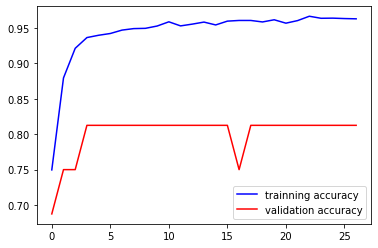

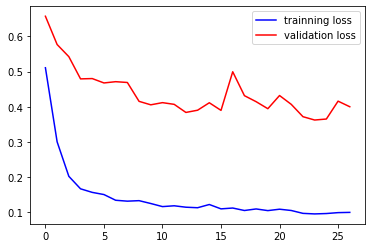

In [17]:
# visualization

import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [18]:
# predict classes

prediction = model.predict_classes(X_test)
prediction = prediction.reshape(1, -1)[0]
prediction[:15]

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0], dtype=int32)

In [19]:
# correct and incorrect
# you can check tensorflow website

correct = np.nonzero(prediction == y_test)[0]
incorrect = np.nonzero(prediction != y_test)[0]

# Visualize some correct

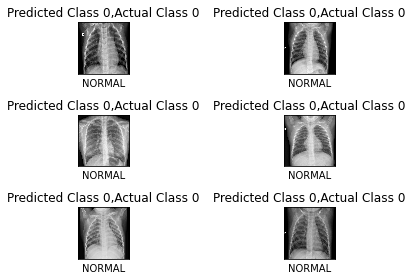

In [20]:
j = 0
for i in correct[:6]:
    plt.subplot(3,2,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i].reshape(256,256), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(prediction[i], y_test[i]))
    plt.xlabel(labels[prediction[i]])
    plt.tight_layout()
    j += 1

# Some inccorect visualization

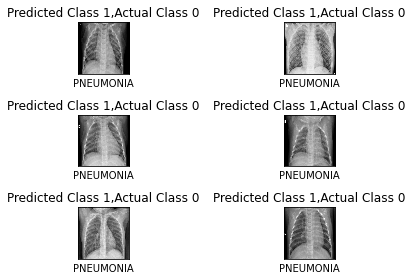

In [21]:
j = 0
for i in incorrect[:6]:
    plt.subplot(3,2,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i].reshape(256,256), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(prediction[i], y_test[i]))
    plt.xlabel(labels[prediction[i]])
    plt.tight_layout()
    j += 1

In [22]:
# load model and predict some some external photo

labels = ["NORMAL", "PNEUMONIA"]
def prepare(filepath):
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

model = tf.keras.models.load_model("cnn_model.bin") # load model

In [23]:
# extra pneumonia photo from google
prediction = model.predict([prepare("../input/images/left-lower-lobe-pneumonia.jpg")])
print(labels[int(prediction[0])])

PNEUMONIA


In [24]:
# extra normal x-ray photo from google
prediction = model.predict([prepare("../input/images/normal.jpeg")])
print(labels[int(prediction[0])])

NORMAL


In [25]:
prediction = model.predict([prepare("../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg")])
print(labels[int(prediction[0])])

PNEUMONIA


In [26]:
prediction = model.predict([prepare("../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person101_bacteria_486.jpeg")])
print(labels[int(prediction[0])])

PNEUMONIA
